# <p style="text-align: center;"> Анализ оттока клиентов банка "Метанпром"</p>

Отдел маркетинга банка "Метанпром" обратился с запросом на выявление сегментов клиентов, склонных к уходу из банка, чтобы на основе сегментации применить рекомендации по удержанию клиентов и получить результаты в кракткосрочном периоде.

**Цель проекта:**  подготовка рекомендаций для отдела маркетинга на основе анализа оттока клиентов банка.

**Задачи проекта:** 
1. Изучение данных:    
    1.1. Найти корреляции;    
    1.2. Сформировать портреты клиентов, которые склонны и не склонны уходить из банка;
2. Сформулировать и проверить статистические гипотезы;    
3. Обобщить признаки отточности, сформулировать сегменты и отобрать из них лучшие;
4. Сформулировать рекомендации для отдела маркетинга.

# Описание датасета

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в
Ярославле и областных городах: Ростов Великий и Рыбинск.
Колонки:
* `USERID` — идентификатор пользователя,
* `score` — баллы кредитного скоринга,
* `city` — город,
* `gender` — пол,
* `age` — возраст,
* `equity` — количество баллов собственности
* `balance` — баланс на счёте,
* `products` — количество продуктов, которыми пользуется клиент,
* `credit_card` — есть ли кредитная карта,
* `last_activity` — активный клиент,
* `EST_SALARY` — оценочный доход клиента,
* `сhurn` — признак оттока.

# Часть 1 - Загрузка и предобработка данных

In [1]:
# загружаем необходимые библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import itertools
from statsmodels.stats.proportion import proportions_ztest

In [2]:
try:
    df = pd.read_csv('/datasets/bank_scrooge.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')

In [3]:
# посмотрим содержание датасета

df.head(15)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0


In [4]:
# переименуем столбцы 'USERID' и 'EST_SALARY'

df = df.rename (columns = {'USERID':'user_id', 'EST_SALARY':'est_salary'})
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [5]:
# выведем на экран количество пропусков для каждого из столбцов

df.isnull().sum()

user_id             0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

In [6]:
# пропусков в столбце 'age' всего 26, заменим их медианой

df['age'] = df['age']. fillna(df['age'].median())

In [7]:
# найдём процент пропусков по столюцу 'balance'

df['balance'].isna().sum()/len(df)*100

22.95

В столбце `balance` пропусков 23%  - значимая доля, чтобы их удалять. Проанализируем эти пропусти позже, чтобы решить что с ними делать.

In [8]:
# исследуем соответствие типов данных

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [9]:
# изменим тип данных в столбце 'age' на int

df['age'] = df['age'].astype('int')

In [10]:
# проверим полные дубликаты в датасете

df.duplicated().sum()

0

In [11]:
# найдем процент дубликатов в столбце 'user_id'

df['user_id'].duplicated().sum()/len(df)*100

0.73

Дубликатов по `user_id` ~1%. Можем удалить, а можем попробовать проанализировать их для повышения точности результата.
Проверим совпадает ли между дубликатами по `user_id` ещё такие надёжные для идентификации пользователей поля как пол и возраст.

In [12]:
df.duplicated(['user_id','gender', 'age']).sum()

3

Таких дубликатов всего 3. Посмотрим на них вручную.

In [13]:
df[df.duplicated(['user_id','gender', 'age'], False)]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3274,155765,863.0,Ярославль,М,30,5,1036114.50,5,1,1,150744.50,1
3668,185829,925.0,Рыбинск,М,40,0,NaN,1,1,0,228305.64,0
5197,155765,923.0,Рыбинск,М,30,0,NaN,1,1,1,120296.60,0
8205,227795,840.0,Рыбинск,М,34,2,350768.03,1,1,0,102036.14,1
8497,227795,839.0,Ярославль,М,34,2,326593.14,2,1,0,103314.92,0
9632,185829,927.0,Ярославль,М,40,0,NaN,1,1,0,231254.86,0


Нельзя утвержать что это дубликаты пользователей т.к. есть разница по остальным полям.
Т.е. во всех дубликатах по `user_id` данные отличаются.
Есть гипотеза, что дубликаты `user_id` возникли при выгрузке данных из разных источников.

In [14]:
# проверим есть ли дубликаты пользователй из одного города
df.duplicated(['user_id','city']).sum()

0

Нет дубликатов из одного города, что подтверждает нашу гипотезу.<br>
Поле `user_id` содержит противоречивую информацию.<br>
Т.к. поле `user_id` нам не требуется, для анализа данных, то его можно оставить как есть.

In [15]:
# проверим корректность данных в столбцах с количественными характеристиками

df[['score','age','equity','balance','products','est_salary']].describe().applymap('{:,.2f}'.format)

,score,age,equity,balance,products,est_salary
count,"10,000.00","10,000.00","10,000.00","7,705.00","10,000.00","10,000.00"
mean,848.70,42.73,2.63,"827,794.31",1.87,"147,866.89"
std,65.45,12.16,1.98,"1,980,614.15",0.79,"139,388.51"
min,642.00,18.00,0.00,0.00,0.00,"2,546.30"
25%,802.00,33.00,0.00,"295,554.16",1.00,"75,251.90"
50%,853.00,40.00,3.00,"524,272.20",2.00,"119,658.10"
75%,900.00,51.00,4.00,"980,705.85",2.00,"174,500.54"
max,"1,000.00",86.00,9.00,"119,113,552.01",5.00,"1,395,064.45"


Есть данные с аномальными значениями. В столбце `products` есть нулевые значения, клиенты без продуктов.

In [16]:
# количство записей с нулевым значением products

df[df['products'] == 0]['user_id'].count()

1

In [17]:
# одна уникальная запись. тогда скорее всего это человеческая ошибка. заменим на минимальное значение - 1.

df.loc[df['products'] == 0, 'products'] = 1

In [18]:
# проверим уникальные значения в столбце 'city'

df['city'].unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

In [19]:
# проверим уникальные значения в столбце 'gender'

df['gender'].unique()

array(['Ж', 'М'], dtype=object)

В столбцах с категориальными переменными набор значений верный: 3 города и 2 пола.

In [20]:
# проверим уникальные значения в столбце 'credit_card'

df['credit_card'].unique()

array([0, 1])

In [21]:
# проверим уникальные значения в столбце 'last_activity'

df['last_activity'].unique()

array([1, 0])

In [22]:
# проверим уникальные значения в столбце 'churn'

df['churn'].unique()

array([1, 0])

В столбцах `credit_card`, `last_activity`, `churn` набор значений верный.

Теперь типы данных приведены корректно, но столбцы `city` и `gender` имеют тип object, что будет создавать неудобства при дальнейших расчетах. Необходимо их закодировать. Для этого создадим копии этих столбцов.

In [23]:
# создадим копии столбцов 'city' и 'gender'

df['city_2']=df['city']
df['gender_2']=df['gender']
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_2,gender_2
0,183012,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,Рыбинск,Ж
1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,Рыбинск,Ж
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,Рыбинск,Ж
3,225363,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,Ярославль,Ж
4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,Ярославль,М


In [24]:
# закодируем данные в столбцах city_2 и gender_2:

df = pd.get_dummies(df, columns = ['city_2', 'gender_2'])
df = df.rename (
    columns = ({
        'city_2_Ростов':'Ростов', 'city_2_Рыбинск':'Рыбинск','city_2_Ярославль':'Ярославль', 
        'gender_2_Ж':'female', 'gender_2_М':'male'}))
display(df.head())

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Ростов,Рыбинск,Ярославль,female,male
0,183012,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,0,1,0,1


Попробуем выяснить с чем могут быть связаны пропуски в столбце `balance`.<br />

In [25]:
# посмотрим средние значения столбцов в датасете с пропусками 'balance' и без

group_blalance_1 = df[df['balance'].notna()].mean(numeric_only=True)
group_blalance_0 = df[df['balance'].isna()].mean(numeric_only=True)

pd.concat({'balance_notna_mean': group_blalance_1,
           'balance_isna_mean': group_blalance_0,
           "Разница %": (group_blalance_0/group_blalance_1-1)*100},axis=1)

,balance_notna_mean,balance_isna_mean,Разница %
user_id,171738.837508,172069.447930,0.192508
score,843.739260,865.352070,2.561551
age,42.920571,42.078431,-1.962089
equity,3.395068,0.050980,-98.498399
balance,827794.306510,NaN,NaN
products,2.080986,1.162527,-44.135759
credit_card,0.640104,0.815686,27.430307
last_activity,0.515769,0.549455,6.531288
est_salary,124501.872366,226310.208654,81.772534
churn,0.234523,0.005664,-97.584677


 Средние значения по столбцам `equity`, `products`, `churn`, `est_salary` значительно отличаются. Значит эти пропуски нельзя обьяснить случайным техническим сбоем.

Создадим новую характеристику клиента `balance_na` - отсутствие баланса, чтобы можно было проанализировать характер её связи с другими данными.

In [26]:
df['balance_na']=df['balance']
df['balance_na'] = df['balance_na'].apply(lambda x: 1 if pd.isna(x) else 0)

In [27]:
# посчитаем корреляцию 'balance_na' с остальными характеристиками

df.corrwith(df['balance_na']).sort_values(key=abs).apply('{:.2f}'.format)

user_id           0.00
Рыбинск          -0.01
last_activity     0.03
age              -0.03
Ярославль         0.06
Ростов           -0.06
female           -0.06
male              0.06
score             0.14
credit_card       0.16
churn            -0.25
est_salary        0.31
products         -0.49
equity           -0.71
balance_na        1.00
balance            nan
dtype: object

Видим множественные корреляции, значит нет возможности выделить какую-либо одну зависимость пропусков от остальных данных, поэтому мы не сможем выделить какой-либо один сегмент с линейной зависимостью и заполнить по ней пропуски.<br />
Опираясь на значениям корреляции можно выдвинуть несколько предположений:<br/>
- Сильная обратная корреляция с отточностью `churn`, количеством продуктов `products` и залоговой собственностью `equity` - это могут быть новые пользователи и поэтому у них ещё нет продуктов, счёта, и оценки собственности.<br/>
- Сильная корреляция с наличием кредитной карты - это могут быть клиенты у которых из продуктов только кредитка и поэтому нет дебетового счёта.<br/>

**Вывод:**<br>
Проведена предобработка данных:
1. переименованы столбцы `USERID` и `EST_SALARY`;
2. изменен тип данных в столбце `age` с float на int;
3. полных дубликатов не обнаружено;
4. проанализированы дубликаты дубликаты в столбце `user_id`;
5. столбцах `gender` и `city` применена кодировка данных для удобства дальнейший расчетов;
6. пропуски в столбце `age` заменены медианой, пропуски в столбце `balance` оставлены без изменений.

# Часть 2 - Исследовательский анализ данных

Рассмотрим центральные тенденции характеристик в разрезе оттока.<br />
для категориальных и бинарных типов характеристик - среднее.<br />
для непрерывных типов характеристик - медианы. <br />

In [30]:
# рассмотрим центральные тенденции характеристик в разрезе оттока

df_churn = df.groupby('churn').agg({
                         'churn': 'count',
                         'equity': 'mean',
                         'products': 'mean', 
                         'credit_card': 'mean', 
                         'last_activity': 'mean', 
                         'Ростов': 'mean', 
                         'Рыбинск': 'mean', 
                         'Ярославль': 'mean', 
                         'female': 'mean', 
                         'male': 'mean', 
                         'score' : 'median', 
                         'age': 'median', 
                         'balance': 'median', 
                         'balance_na': 'mean', 
                         'est_salary': 'median'}).rename(columns = {'churn':'count'})
display(df_churn)

,count,equity,products,credit_card,last_activity,Ростов,Рыбинск,Ярославль,female,male,score,age,balance,balance_na,est_salary
churn,,,,,,,,,,,,,,,
0,8180,2.374817,1.757579,0.709169,0.483741,0.140709,0.276039,0.583252,0.532763,0.467237,848.0,40,475382.445,0.278973,118257.715
1,1820,3.763736,2.376374,0.551099,0.702198,0.146154,0.240110,0.613736,0.350000,0.650000,866.0,39,782410.470,0.007143,125390.620


In [31]:
# сравним центральные тенденции характеристик отточных и неотточных клиентов

pd.concat({
    'Не отточные': df_churn.iloc[0],
    'Отточные': df_churn.iloc[1],
    'Разница %': (df_churn.iloc[1]/df_churn.iloc[0]-1)*100},
    axis=1).sort_values('Разница %')


,Не отточные,Отточные,Разница %
balance_na,0.278973,0.007143,-97.439589
count,8180.000000,1820.000000,-77.750611
female,0.532763,0.350000,-34.304727
credit_card,0.709169,0.551099,-22.289450
Рыбинск,0.276039,0.240110,-13.015992
age,40.000000,39.000000,-2.500000
score,848.000000,866.000000,2.122642
Ростов,0.140709,0.146154,3.869545
Ярославль,0.583252,0.613736,5.226633
est_salary,118257.715000,125390.620000,6.031661


Получившиеся группы достаточного размера, чтобы можно было воспользоваться стат. методами для их сравнения.

Между средними отточными и неотточными клиентами есть сильная (>10%) разница по следующим характеристикам:<br />
balance, equity, last_activity, male, products, credit_card

Характеристики по которым разница в отточности проявляется слабо:<br />
est_salary, Ярославль, Ростов, score, age<br />
По ним нужно провести анализ более детально:<br />

Для количественных непрерывных характеристик построим график плотности распределение в разрезе оттока.

In [32]:
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

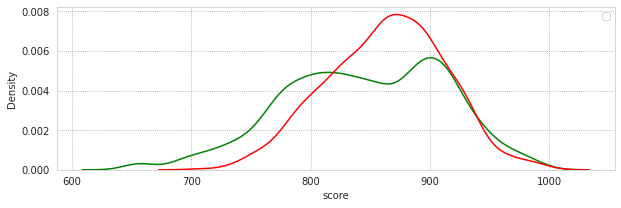

In [33]:
# визуализируем взаимосвязь 'churn' - 'score'

plt.figure(figsize=(10,3))
plt.legend(['Не отточные', 'Отточные'])
sns.kdeplot(df[df['churn'] == 0]['score'], clip=(0.0, 2000000.0), common_norm=False, color='green')
sns.kdeplot(df[df['churn'] == 1]['score'], clip=(0.0, 2000000.0), common_norm=False, color='red')
plt.show()

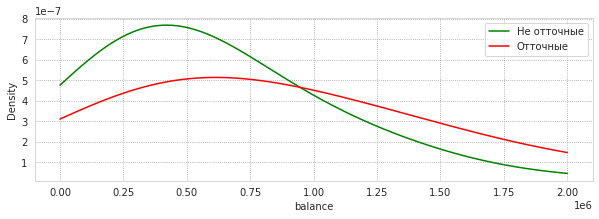

In [34]:
# визуализируем взаимосвязь 'churn' - 'balance'

plt.figure(figsize=(10,3))
sns.kdeplot(df[df['churn'] == 0]['balance'], clip=(0.0, 2000000.0), common_norm=False, color='green')
sns.kdeplot(df[df['churn'] == 1]['balance'], clip=(0.0, 2000000.0), common_norm=False, color='red')
plt.legend(['Не отточные', 'Отточные'])
plt.show()

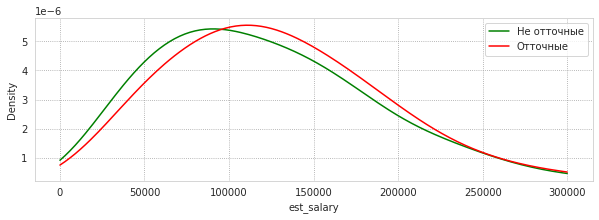

In [35]:
# визуализируем взаимосвязь 'churn' - 'est_salary'

plt.figure(figsize=(10,3))
sns.kdeplot(df[df['churn'] == 0]['est_salary'], clip=(0.0, 300000.0), common_norm=False, color='green')
sns.kdeplot(df[df['churn'] == 1]['est_salary'], clip=(0.0, 300000.0), common_norm=False, color='red')
plt.legend(['Не отточные', 'Отточные'])
plt.show()

Для дискретных характеристик построим гистограмму распределение в разрезе оттока

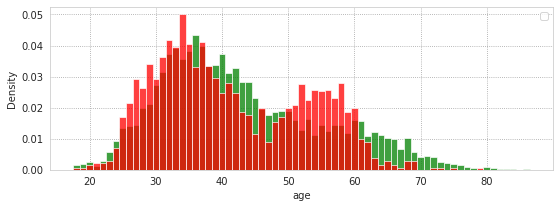

In [36]:
plt.figure(figsize=(9,3))
plt.legend(['Не отточные', 'Отточные'])
sns.histplot(df[df['churn'] == 0]['age'], discrete=True, stat='density', common_norm=False, color='Green');
sns.histplot(df[df['churn'] == 1]['age'], discrete=True, stat='density', common_norm=False, color='Red');
plt.show()

Распределения по возрасту в разрезе оттока перекрывают друг друга на разных интервалах. 
Разделим отточных клиентов по возрастным группам: <br>
18-24 <br>
25-35 <br>
36-50 <br>
51-60 <br>
60+

In [37]:
# создадим функцию age_cat для распределения клиентов по возрастным группам

def age_cat(age):
    if 18 <= age <= 24:
        return '18-24'
    if 25 <= age <= 35:
        return '25-35'
    if 36 <= age <= 50:
        return '36-50'
    if 51 <= age <= 60:
        return '51-60'
    if 61 <= age:
        return '60+'
    
df['age_cat'] = df['age'].apply (age_cat)

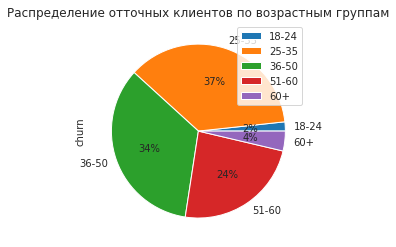

In [38]:
df.groupby(['age_cat']).agg({'churn': 'sum'}).plot(
    kind='pie',
    y='churn',
    autopct='%1.0f%%',
    title='Распределение отточных клиентов по возрастным группам'); 

Для категориальных характеристик построим столбчатую диаграмму уровня оттока

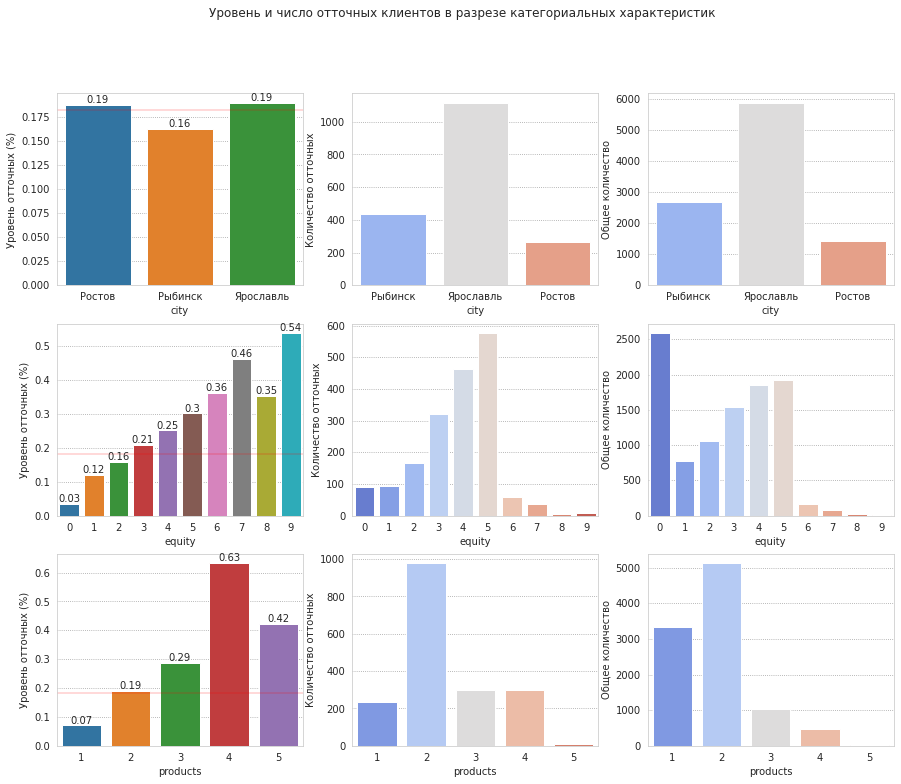

In [40]:
churn_mean=df['churn'].mean()
fig, axes = plt.subplots(3,3, figsize=(15, 12))
n=0
for categorical in ['city', 'equity', 'products']:
    # выводим количество отточных клиентов в категории
    sns.countplot(data=df[df['churn'] == 1], x=categorical, palette="coolwarm", ax=axes[n][1])
    axes[n][1].set_ylabel("Количество отточных")

    # выводим количество всех клиентов в категории
    sns.countplot(data=df, x=categorical, palette="coolwarm", ax=axes[n][2])
    axes[n][2].set_ylabel("Общее количество")

    # выводим уровень отточности клиентов в категории
    levels=df.groupby(categorical).agg({'churn': 'mean'}).reset_index()
    sns.barplot(data=levels, x=categorical, y='churn', ax=axes[n][0])
    axes[n][0].axhline(y=churn_mean, color='red', alpha=0.2)
    axes[n][0].set_ylabel("Уровень отточных (%)")
    # выводим метки на barplot
    #axes[n][0].bar_label(axes[n][0].containers[0], fmt='%.2f%%', label_type='center')
    labels=levels['churn'].values.round(2)
    rects=axes[n][0].containers[0].patches
    for rect, label in zip(rects, labels):
        axes[n][0].text(rect.get_x() + rect.get_width()/2, rect.get_height(), label, ha="center", va="bottom")

    n+=1
fig.suptitle("Уровень и число отточных клиентов в разрезе категориальных характеристик");
plt.show()

In [42]:
### КОД РЕВЬЮЕРА 2
libs = !pip list

for lib in libs:
    if lib.startswith('pand'):
        print(lib)

pandas                            1.2.4
pandocfilters                     1.4.2


Построим пироговые диаграммы для категориальных характеристик

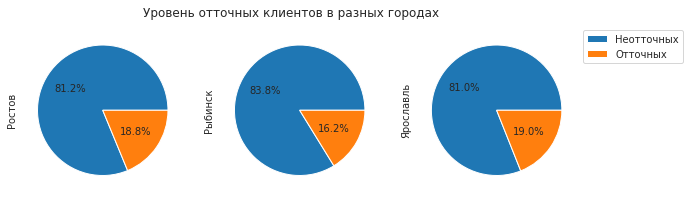

In [43]:
figure, axis = plt.subplots(1,3, figsize=(10, 3))
figure.suptitle("Уровень отточных клиентов в разных городах");

df.groupby('churn').agg({'Ростов': 'sum'}).plot(ax=axis[0],kind='pie',y='Ростов',autopct='%0.1f%%',legend=False,labeldistance=None);
df.groupby('churn').agg({'Рыбинск': 'sum'}).plot(ax=axis[1],kind='pie',y='Рыбинск',autopct='%0.1f%%',legend=False,labeldistance=None);
df.groupby('churn').agg({'Ярославль': 'sum'}).plot(ax=axis[2],kind='pie',y='Ярославль',autopct='%0.1f%%',legend=False,labeldistance=None);
axis[2].legend(['Неотточных','Отточных'], bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

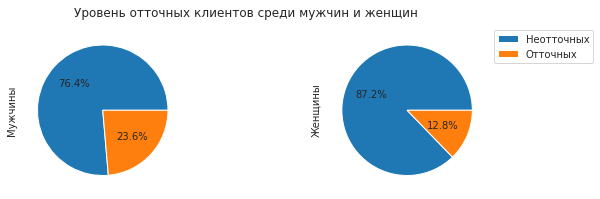

In [44]:
figure, axis = plt.subplots(1,2, figsize=(10, 3))
figure.suptitle("Уровень отточных клиентов среди мужчин и женщин");

df.groupby('churn').agg({'male': 'sum'}).plot(ax=axis[0],kind='pie',y='male',autopct='%0.1f%%',legend=False,labeldistance=None);
df.groupby('churn').agg({'female': 'sum'}).plot(ax=axis[1],kind='pie',y='female',autopct='%0.1f%%',legend=False,labeldistance=None);
axis[1].legend(['Неотточных','Отточных'], bbox_to_anchor=(1, 1.02), loc='upper left')
axis[0].set(ylabel='Мужчины')
axis[1].set(ylabel='Женщины')
plt.show()

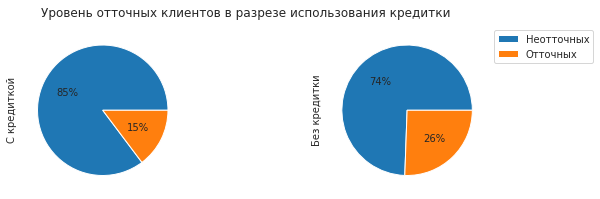

In [45]:
figure, axis = plt.subplots(1,2, figsize=(10, 3))
figure.suptitle("Уровень отточных клиентов в разрезе использования кредитки");

churn_level=df.groupby(['credit_card']).agg({'churn':'mean'})['churn']
axis[1].pie(x=[1 - churn_level.loc[0],churn_level.loc[0]],autopct='%.0f%%')
axis[0].pie(x=[1 - churn_level.loc[1],churn_level.loc[1]],autopct='%.0f%%')
axis[1].legend(['Неотточных','Отточных'], bbox_to_anchor=(1, 1.02), loc='upper left')
axis[0].set(ylabel='С кредиткой')
axis[1].set(ylabel='Без кредитки')
plt.show()

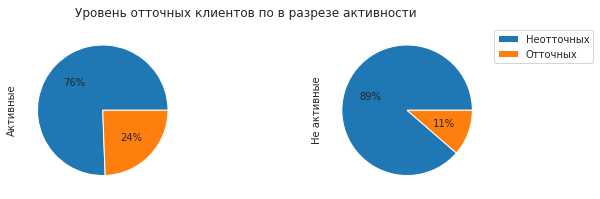

In [46]:
figure, axis = plt.subplots(1,2, figsize=(10, 3))
figure.suptitle("Уровень отточных клиентов по в разрезе активности");

churn_level=df.groupby(['last_activity']).agg({'churn':'mean'})['churn']
axis[1].pie(x=[1 - churn_level.loc[0],churn_level.loc[0]],autopct='%.0f%%')
axis[0].pie(x=[1 - churn_level.loc[1],churn_level.loc[1]],autopct='%.0f%%')
axis[1].legend(['Неотточных','Отточных'], bbox_to_anchor=(1, 1.02), loc='upper left')
axis[0].set(ylabel='Активные')
axis[1].set(ylabel='Не активные')
plt.show()

**Вывод:**
Выделим, на основе получившихся графиков, признаки оказывающие наибольшее влияние на отток клиентов:
- баллы кредитного рейтинга `score` от 820 до 910
- баланс `balance` от 950K
- оценочный доход клиента `est_salary` от 100K до 230K
- возраст `age` о 25 до 35 либо от 50 до 60
- баллов собственности `equity` больше или равно 3
- продуктов `products` больше или равно 3
- пол `gender` мужчина
- кредитной карты `credit_card` нет 
- активен `last_activity` да
<br />

Разница уровня оттока по городам очень мала, проверим её ниже с помощью метода гипотиз.

# Часть 3 - Проверка статистических гипотез

Гипотеза №1: о различии дохода между клиентами, которые ушли и которые остались<br>

H_0: доходы оставшихся и отточных клиентов равны;<br>
H_1: доходы оставшихся и отточных клиентов не равны.<br>

Для проверки гипотезы проведем t-test и u-test<br>
alpha = 0.05 # критический уровень статистической значимости

Чтобы понять, можно ли применять t-тест, нужно проверить три условия:
1. Генеральные совокупности не зависят друг от друга. 
2. Выборочные средние нормально распределены. 
3. Дисперсии рассматриваемых генеральных совокупностей равны.

Проверим наши генеральные совокупности на соответствие критериям для проведения t-testa

In [47]:
a = df[df['churn'] == 1]['est_salary']
b = df[df['churn'] == 0]['est_salary']

<AxesSubplot:xlabel='est_salary', ylabel='Count'>

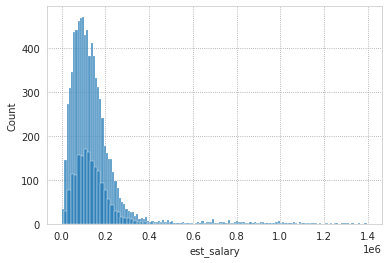

In [48]:
sns.histplot(df[df['churn'] == 0]['est_salary'])
sns.histplot(df[df['churn'] == 1]['est_salary'])

In [49]:
# проведём тест на соотвествие данных о доходах отточных клиентов нормальному распределеню

alpha = 0.05  # критический уровень статистической значимости

shapiro_test_stat, p_value = st.shapiro(a)

print('p-значение: ', p_value)
if p_value < alpha:
    print('Распределение не нормально')
else:
    print('Нормальное распределение')  

p-значение:  0.0
Распределение не нормально


In [50]:
# проведём тест на соотвествие данных о доходах неотточных клиентов нормальному распределеню

alpha = 0.05  # критический уровень статистической значимости

shapiro_test_stat, p_value = st.shapiro(b)

print('p-значение: ', p_value)
if p_value < alpha:
    print('Распределение не нормально')
else:
    print('Нормальное распределение') 

p-значение:  0.0
Распределение не нормально


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [51]:
# оценим дисперсии

print(df[df['churn'] == 0]['est_salary'].var())
print(df[df['churn'] == 1]['est_salary'].var())

20392519451.455894
15107976364.850912


**Вывод:**
1. Генеральные совокупности не зависят друг от друга;
2. Распределение значений не является нормальным;
3. Дисперсии не равны.<br>
При отсутствии нормального распределения сравниваемых выборок вместо t-критерия Стьюдента используются аналогичные методы непараметрической статистики, среди которых наиболее известными является U-критерий Манна — Уитни.<br>
**Таким образом, выборки не подходят для проведения t-testa**

In [52]:
# проведем t-test

alpha = 0.05

results = st.ttest_ind(a, b)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.8987254468291451
Не получилось отвергнуть нулевую гипотезу


In [53]:
# проведем u-test

alpha = 0.05  

results = st.mannwhitneyu(a, b)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
    ) 

p-значение:  0.000243559272811695
Отвергаем нулевую гипотезу


**Вывод:** В данном случае, распределение не является нормальным, поэтому был выбран непараметрический тест U-критерий Манна — Уитни.<br>

Таким образом, отвергаем нулевую гипотезу, доходы оставшихся и отточных клиентов не равны

Гипотеза №2: о влиянии георгафии на отток<br>

H_0: отток зависит от города клиента;<br>
H_1: отток не зависит от города клиента.<br>

Для проверки гипотезы проведем t-test и u-test<br>
alpha = 0.05

Чтобы понять, можно ли применять t-тест, нужно проверить три условия:
1. Генеральные совокупности не зависят друг от друга. 
2. Выборочные средние нормально распределены. 
3. Дисперсии рассматриваемых генеральных совокупностей равны.<br>
**Проверим наши генеральные совокупности на соответствие критериям для проведения t-testa**

In [54]:
# выведем набор значений в выборках
print(df[df['city'] == 'Ростов']['churn'].unique())
print(df[df['city'] == 'Рыбинск']['churn'].unique())
print(df[df['city'] == 'Ярославль']['churn'].unique())

[0 1]
[1 0]
[1 0]


Выборки являются набором бинарных значений, поэтому t-test который предназначен для нормально распределённых данных, применять нельзя. Сравнение средних не даст корректного результата. 

Проведём c помощью библиотеки statsmodels z-test для проверки гипотезы.

In [55]:
# проведем z-test для категории города

# критический уровень статистической значимости
alpha = 0.05

# уровень оттока генеральной совокупности
churn_val = df['churn'].mean()

for city in ['Ростов', 'Рыбинск', 'Ярославль']:

    # количество испытаний
    nobs = df[df['city']==city]['churn'].count()

    # количество успешных
    successes = df[(df['city']==city) & (df['churn']==1)]['churn'].count()

    # z-test
    z_stat, pval = proportions_ztest(successes, nobs, churn_val)

    print('p-значение:', '{0:0.3f}'.format(pval))

    if pval < alpha:
        print('Отвергаем нулевую гипотезу для города', city)
    else:
        print('Не получилось отвергнуть нулевую гипотез удля города', city)

p-значение: 0.581
Не получилось отвергнуть нулевую гипотез удля города Ростов
p-значение: 0.005
Отвергаем нулевую гипотезу для города Рыбинск
p-значение: 0.131
Не получилось отвергнуть нулевую гипотез удля города Ярославль


In [57]:
# проведем u-test для категории города

# критический уровень статистической значимости
alpha = 0.05

for city in ['Ростов', 'Рыбинск', 'Ярославль']:
    utest_stat, pval = st.mannwhitneyu(df['churn'], df[df['city']==city]['churn'])
    print('p-значение: ', pval)
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу для города', city)
    else:
        print('Не получилось отвергнуть нулевую гипотезу для города', city) 

p-значение:  0.6020203980124814
Отвергаем нулевую гипотезу для города Ростов
p-значение:  0.016767897530501296
Отвергаем нулевую гипотезу для города Рыбинск
p-значение:  0.22676024447809306
Отвергаем нулевую гипотезу для города Ярославль


**Вывод по u-тесту:** Таким образом, отток не зависит от города клиента.

**Вывод:** 
1. Доходы отточных и неотточных клиентов не равны;
2. Отток не зависит от города клиента.

# Часть 4 - Промежуточный итог

Признаки которые получились на основе анализа графиков:
- баллы кредитного рейтинга `score` от 820 до 910
- баланс `balance` от 950K
- оценочный доход клиента `est_salary` от 100K до 230K
- возраст `age` о 25 до 35 либо от 50 до 60
- баллов собственности `equity` больше или равно 3
- продуктов `products` больше или равно 3
- пол `gender` мужчина
- кредитной карты `credit_card` нет 
- активен `last_activity` да

В ходе проверки гипотез был отброшен признак принадлежности к городу.<br />
Был подтверждён признак зависимости оттока от дохода.<br />
<br />

По графику распределению оттока по возрасту, можно заметить две группы отточных клиентов:<br />
25-35 лет<br />
50-60 лет<br />
очень удобно будет разбить по этому признаку выделить 2 сегмента, а третим сделать сегмент не зависящий от возраста. 

# Часть 5 - Сегментация клиентов и приоретезация

Построим карту корреляции чтобы проанализировать зависимости между категориями и возможно или совсем отбросить излишние характеристики при сильной корреляци, или учесть что ин стоит разнести по разным сегментам в случает наличия умеренной корреляции.

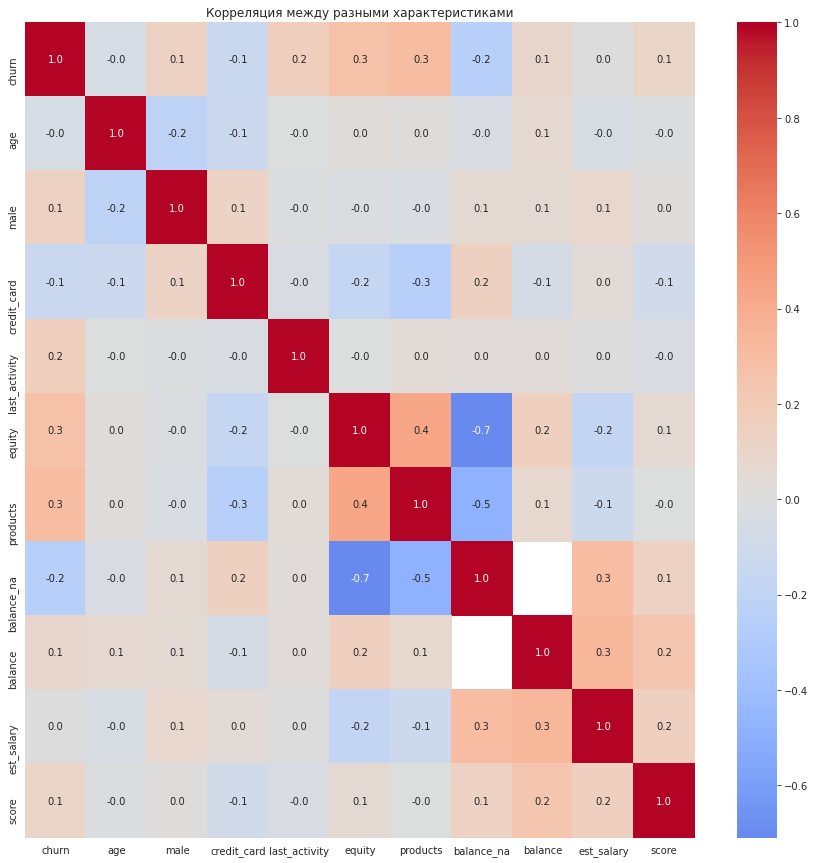

In [58]:
correlation = df[['churn',
                  'age',
                  'male',
                  'credit_card',
                  'last_activity',
                  'equity',
                  'products',
                  'balance_na',
                  'balance',
                  'est_salary',
                  'score'
                 ]].corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, center=0, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Корреляция между разными характеристиками')
plt.show()

По шкале Чеддока, корреляцию оттока с характеристиками можно оценить как:<br />
слабая - age, male, credit_card, last_activity, balance_na, balance, est_salary, score.
умеренная - equity, products.<br />

Можно заметить умеренную корреляцию между balance, est_salary и score. Поэтому лучше стараться выносить эти признаки в разные сегменты, чтобы максимизировать покрытие.

Довольно сложно вручную сразу уметь подбирать сегменты. Поэтому воспользуемся методом перебора комбинаций сегментов. Но из списка результатов автоматического перебора будем выбирать не первый попавшийся (топовый) набор, а выберём такой чтобы учесть те замечания которые делали в предыдущих разделах.

Перебор сегментов, посчёт их отточности:

In [59]:
# средняя отточность по датасету
gauge_churn = df['churn'].mean()
print('Средняя отточность по банку:',"{:.2%}".format(gauge_churn),'\n')

# формализованный набор условий на основе признаков отточности 
c=[ '',
    'equity >= 3' ,
    'last_activity == 1',
    'male == 1',
    '100000 <= est_salary <= 230000',
    'credit_card == 0',
    '25 <= age <= 35',
    '50 < age <= 60',
    '820 <= score <= 910',
    'balance > 950000'
]

gauge_churn = df['churn'].mean()

# вычисление отточности сегмента и проверка размера
def query_churn_mean(q):
    if q == '':
        return 0
    cm = df.query(q).agg({"churn":['mean','count']}).values
    if cm[1] < 500:
        #print('too small')
        return 0
    if cm[1] > 5000:
        #print('too big')
        return 0
    else:
        return round(cm[0][0],2)

# соединяем признаки в сегмент
def query_concat(a,op):
    q=''
    for i in a:
        if i != '':
            q = i if q == '' else q + op + i
    return q

# соединяем сегменты в одну выборку
def query_concat_or(a):
    q=''
    for i in a:
        if i != '':
            q = '(' + i if q == '' else q + ') or (' + i
    return q + ')'


best_k=0
best_q=''
i=0

for x in list(itertools.permutations([0,1,2,3], 3)):
    for y in list(itertools.permutations([0,4,5,6], 3)):
        for z in list(itertools.permutations([0,7,8,9], 3)):
            i+=1
         
            if i > 1000:
                break
            #print(x[0],y[0],z[0],' | ',x[1],y[1],z[1],' | ',x[2],y[2],z[2])
            segment_1=query_concat([c[x[0]],c[y[0]],c[z[0]]],' and ')
            segment_2=query_concat([c[x[1]],c[y[1]],c[z[1]]],' and ')
            segment_3=query_concat([c[x[2]],c[y[2]],c[z[2]]],' and ')
            #print(q1,'|',q2,'|',q3)
            q1_k=query_churn_mean(segment_1)
            q2_k=query_churn_mean(segment_2)
            q3_k=query_churn_mean(segment_3)
            # проверяем условие по отточности сегментов
            if q1_k > 2*gauge_churn and q2_k > 2*gauge_churn and q3_k > 2*gauge_churn:
                q = query_concat_or([segment_1,segment_2,segment_3])
                t_k=query_churn_mean(q)
                if t_k > best_k:
                    best_q = q
                    best_k = t_k
                    print('+ Найден более отточный набор Churn mean:',best_k,'(',q1_k,q2_k,q3_k,');',
                          'Churn count: ',df.query(best_q)['churn'].sum())
                    print('Сегменты:\n', best_q.replace(" or ", "\n "),'\n')

print('Завершение за итераций:',i)

Средняя отточность по банку: 18.20% 

+ Найден более отточный набор Churn mean: 0.38 ( 0.42 0.37 0.46 ); Churn count:  970
Сегменты:
 (100000 <= est_salary <= 230000 and balance > 950000)
 (equity >= 3 and 50 < age <= 60)
 (last_activity == 1 and credit_card == 0 and 820 <= score <= 910) 

+ Найден более отточный набор Churn mean: 0.39 ( 0.42 0.37 0.45 ); Churn count:  1015
Сегменты:
 (100000 <= est_salary <= 230000 and balance > 950000)
 (equity >= 3 and 50 < age <= 60)
 (last_activity == 1 and 25 <= age <= 35 and 820 <= score <= 910) 

+ Найден более отточный набор Churn mean: 0.4 ( 0.37 0.44 0.45 ); Churn count:  916
Сегменты:
 (credit_card == 0 and 50 < age <= 60)
 (equity >= 3 and 100000 <= est_salary <= 230000 and balance > 950000)
 (last_activity == 1 and 25 <= age <= 35 and 820 <= score <= 910) 

Завершение за итераций: 1535


Как и предпологали, выберем два возрастных сегмента и один по уровню обеспеченности:<br />

**Сегмент #1**

In [62]:
display(df.query('credit_card == 0 and 50 < age <= 60').agg({'churn':['mean','count']}))

,churn
mean,0.366044
count,642.000000


Возраст 50-60 лет<br>
Наличие кредитной карты: нет<br>
Количество клиентов: 642<br>
Уровень отточности: 37%<br>

**Сегмент №2**

In [63]:
display(df.query('equity >= 3 and 100000 <= est_salary <= 230000 and balance > 950000').agg({'churn':['mean','count']}))

,churn
mean,0.435824
count,1044.000000


Баллы собственности более 3<br>
Доход 100,000-230,000<br>
Баланс более  950,000 <br>
Количество клиентов: 1044<br>
Уровень отточности: 44%<br>

**Сегмент №3**

In [64]:
display(df.query('last_activity == 1 and 25 <= age <= 35 and 820 <= score <= 910').agg({'churn':['mean','count']}))

,churn
mean,0.452899
count,828.000000


Возраст 25-35 лет<br>
Кредитный рейтинг 830-910<br>
Активность: да<br>
Количество клиентов: 828<br>
Уровень отточности: 45%<br>

# Часть 6 - Рекомендации

**Сегмент №1**<br>
Возраст 50-60 лет<br>
Наличие кредитной карты: нет<br>
Количество клиентов: 642<br>
Уровень отточности: 37%<br>
**Рекомендации:** <br>
Предложить кредитную карту<br>

**Сегмент №2**<br>
Баллы собственности более 3<br>
Доход 100,000-230,000<br>
Баланс более  950,000 <br>
Количество клиентов: 1044<br>
Уровень отточности: 44%<br>
**Рекомендации:** <br>
Предложить уникальные условия по накопительным счетам<br>
Предложить продукты страхования собственности<br>

**Сегмент №3**<br>
Возраст 25-35 лет<br>
Кредитный рейтинг 830-910<br>
Активность: да<br>
Количество клиентов: 828<br>
Уровень отточности: 45%<br>
**Рекомендации:** <br>
Предложить кредит<br>

Ссылка на презентацию: https://disk.yandex.ru/i/aaWwzE1YZ9_M-Q